# Home Credit Default Risk - Machine Learning Project  

## Project Overview  
This project aims to predict **loan default risk** using historical credit data provided by the **Home Credit dataset**.  
By analyzing multiple financial datasets from past loan applications, we extract insights to improve risk assessment and minimize losses for lenders.  
While this model is trained specifically on Home Credit’s dataset, the process—data collection, preprocessing, feature engineering, and modeling—can be adapted to other financial institutions.  

## Live Application Deployment  
This project is also deployed as an **interactive Angular + Flask application**, allowing users to observe real-time model inference.  
🔗 **Try it here:** [Live Loan Default Predictor](https://ai.fullstackista.com/ai-loan-default-predictor/)  

### Key Steps in the Project  
1. **Understanding the Problem** – Define the objective: predict loan default risk using Home Credit data.  
2. **Data Processing & Feature Engineering** – Process multiple datasets, clean missing values, extract features, and aggregate information.  
3. **Exploratory Data Analysis (EDA)** – Identify trends, correlations, and risk factors in loan applications.  
4. **Merging Datasets** – Integrate primary (`application_train.csv`) and secondary datasets (e.g., `bureau.csv`, `credit_card_balance.csv`) for a unified view.  
5. **Model Training & Hyperparameter Tuning** – Train and optimize models (e.g., LightGBM) for predictive performance.  
6. **Model Evaluation** – Validate performance using metrics such as AUC-ROC.  
7. **Final Prediction** – Apply the trained model to `application_test.csv` and generate predictions.  

## About This Notebook  
This notebook processes the `installments_payments.csv` dataset, which contains applicants' loan repayment behavior.  
Processed features will be merged into the main dataset (`application_train.csv`) for model training.  

## Project Notebooks  

### Main Dataset and Model Training  
- [1. Application Train (Main Dataset)](./01_application_train.ipynb)
- [2. Model Training and Final Pipeline](./02_model_training_pipeline.ipynb)  

### Secondary Datasets Processing  
- [3. Bureau Data](./03_bureau_data.ipynb)  
- [4. Bureau Balance Data](./04_bureau_balance.ipynb)  
- [5. Credit Card Balance](./05_credit_card_balance.ipynb)  
- [6. Previous Applications](./06_previous_applications.ipynb)  
- [7. POS Cash Balance](./07_pos_cash_balance.ipynb)  
- [8. Installments Payments](./08_installments_payments.ipynb) _(Current Notebook)_

### Final Prediction  
- [9. Model Predictions on Test Data](./09_model_predictions.ipynb)  
- [10. Application Test Data Processing](./10_application_test_processing.ipynb)

# Processing `installments_payments.csv` (Loan Repayment Behavior)

## 1. Load Data (`installments_payments.csv`)
We start by loading the dataset and inspecting its structure to understand its key features and statistics.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
# Load dataset 
df_installments_payments = pd.read_csv("/kaggle/input/home-credit-default-risk/installments_payments.csv")

## 2. Initial Data Inspection (`installments_payments.csv`)
Before processing, we inspect the dataset for potential issues such as **infinite values**, **missing values**, and other inconsistencies.

### 2.1 Checking for Infinite Values  
Infinite values (e.g., `inf`, `-inf`) can break numerical calculations and should be identified before proceeding.  
The code below scans for any **positive or negative infinite values** in the dataset.  

In [3]:
# Check for infinite values
print("Checking for infinite values in dataset...")
inf_count = (df_installments_payments == np.inf).sum().sum()
neg_inf_count = (df_installments_payments == -np.inf).sum().sum()

if inf_count > 0 or neg_inf_count > 0:
    print(f"⚠️ Found {inf_count} positive and {neg_inf_count} negative infinite values!")
else:
    print("✅ No infinite values detected.")

Checking for infinite values in dataset...
✅ No infinite values detected.


### 2.2 Checking for Missing Values (NaNs)  
Missing values (**NaNs**) can affect model performance and should be handled properly.  
Here, we count the number of missing values in each column and print the results.

In [4]:
# Check for missing values
missing_values = df_installments_payments.isnull().sum()
missing_values = missing_values[missing_values > 0]  

if not missing_values.empty:
    print("⚠️ Missing values detected in columns:")
    print(missing_values)
else:
    print("✅ No missing values detected.")

⚠️ Missing values detected in columns:
DAYS_ENTRY_PAYMENT    2905
AMT_PAYMENT           2905
dtype: int64


### 2.3 Print Dataset Columns  
To get an overview of the dataset structure, we print the column names.  
This helps us understand the available features and identify any inconsistencies.

In [5]:
# Print column names
print(df_installments_payments.columns)

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')


### 2.4 Detecting Extreme Values (Outliers)  

Extreme values (**outliers**) can skew model performance and lead to **unstable predictions**.  
We detect outliers using **percentile thresholds**:  

- **Above the 99th percentile** → Very large values.  
- **Below the 1st percentile** → Very small values.  

In [6]:
# Check for extreme values using percentile-based thresholds 
print("Checking for extreme values in 'installments_payments' dataset using percentile thresholds...")

# Exclude ID columns from percentile-based detection
extreme_exclude_cols = ['SK_ID_CURR', 'SK_ID_PREV']
extreme_numeric_columns = df_installments_payments.select_dtypes(include=["number"]).drop(columns=extreme_exclude_cols, errors='ignore')

# Compute percentile-based thresholds
extreme_upper_threshold = extreme_numeric_columns.quantile(0.99)
extreme_lower_threshold = extreme_numeric_columns.quantile(0.01)

# Identify extreme values
extreme_large_columns = extreme_numeric_columns.max() > extreme_upper_threshold
extreme_small_columns = extreme_numeric_columns.min() < extreme_lower_threshold

# Print results
if extreme_large_columns.any():
    print(f"⚠️ Columns with very large values (above 99th percentile):\n{extreme_numeric_columns.loc[:, extreme_large_columns].max()}")
if extreme_small_columns.any():
    print(f"⚠️ Columns with very small values (below 1st percentile):\n{extreme_numeric_columns.loc[:, extreme_small_columns].min()}")
if not extreme_large_columns.any() and not extreme_small_columns.any():
    print("✅ No extreme values detected in 'installments_payments' dataset.")

Checking for extreme values in 'installments_payments' dataset using percentile thresholds...
⚠️ Columns with very large values (above 99th percentile):
NUM_INSTALMENT_VERSION        178.000
NUM_INSTALMENT_NUMBER         277.000
DAYS_INSTALMENT                -1.000
DAYS_ENTRY_PAYMENT             -1.000
AMT_INSTALMENT            3771487.845
AMT_PAYMENT               3771487.845
dtype: float64
⚠️ Columns with very small values (below 1st percentile):
DAYS_INSTALMENT      -2922.0
DAYS_ENTRY_PAYMENT   -4921.0
AMT_INSTALMENT           0.0
AMT_PAYMENT              0.0
dtype: float64


### 2.5 Checking Dataset Shape  

The dataset's shape provides a quick view of its size, showing the number of **rows** (loan records) and **columns** (features).  

In [7]:
# Check the shape of the dataset
print("DataFrame Shape:", df_installments_payments.shape)

DataFrame Shape: (13605401, 8)


### 2.6 Viewing Sample Data (`head()`)  

To understand the dataset, we display the **first few rows**.  
This helps verify that data is loaded correctly and gives an initial sense of feature distributions.  

In [8]:
# Display the first few rows
print("First few rows of installments_payments DataFrame:")
display(df_installments_payments.head())

First few rows of installments_payments DataFrame:


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


### 2.7 Dataset Summary (`info()`)  

The `info()` function provides:  
- **Column names and types** (e.g., integer, float, categorical).  
- **Non-null counts** (to check for missing data).  
- **Memory usage**, which is useful for optimizing performance.  

In [9]:
# Get a concise summary of the DataFrame
print("DataFrame Info:")
df_installments_payments.info()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


### 2.8 Descriptive Statistics  

We generate summary statistics for:  
- **Numeric columns** (`describe()`) → Mean, standard deviation, min/max, and quartiles.  
- **Categorical columns** (`describe(include='object')`) → Count of unique values, most frequent categories.  
This helps in **understanding distributions** and identifying possible anomalies.  

In [10]:
# Get summary statistics of columns
print("\nDescriptive Statistics:")
display(df_installments_payments.describe())

# Check for categorical columns before describing
categorical_cols = df_installments_payments.select_dtypes(include=["object"]).columns
if len(categorical_cols) > 0:
    print("\nDescriptive Statistics (Categorical):")
    display(df_installments_payments.describe(include="object"))
else:
    print("\n✅ No categorical columns in the dataset.")


Descriptive Statistics:


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06



✅ No categorical columns in the dataset.


## 3. Initial Data Cleaning (`installments_payments.csv`)
After identifying potential issues, we clean the dataset by handling **infinite values, categorical features, and potential misclassified columns**.

### 3.1 Replacing Infinite Values  
Since infinite values (`inf`, `-inf`) can interfere with model training, we replace them with `NaN` to handle them properly later.  

In [11]:
# Replace infinite values with NaN before handling missing values
df_installments_payments.replace([np.inf, -np.inf], np.nan, inplace=True)
print("✅ Infinite values replaced with NaN.")

✅ Infinite values replaced with NaN.


### 3.2 Converting Categorical Features  
Some columns are stored as `object` or numeric types but should be categorical.  
We identify and convert relevant columns to the **category dtype** for efficiency and proper encoding.  

In [12]:
# Check for potential categorical columns
categorical_candidates = df_installments_payments.select_dtypes(include=['object']).columns.tolist()

# Check numeric columns with low unique values (possible categorical)
low_unique_counts = df_installments_payments.nunique()
numeric_categoricals = low_unique_counts[(low_unique_counts < 20) & (df_installments_payments.dtypes != 'object')].index.tolist()

# Combine detected categorical columns
final_categorical_columns = categorical_candidates + numeric_categoricals

# Convert detected columns to 'category' dtype if any exist
if final_categorical_columns:
    df_installments_payments[final_categorical_columns] = df_installments_payments[final_categorical_columns].astype("category")
    print(f"✅ Converted categorical columns: {final_categorical_columns}")
else:
    print("✅ No categorical columns detected in this dataset. No dtype conversion needed.")

✅ No categorical columns detected in this dataset. No dtype conversion needed.


### 3.3 Checking Unique Values in Categorical Columns  
To ensure correct data types, we print the number of unique values in categorical columns.  
This helps verify if any unexpected categories exist.  

In [13]:
print("Unique values in categorical columns:")
if final_categorical_columns:
    for col in final_categorical_columns:
        print(f"{col}: {df_installments_payments[col].nunique()} unique values")
else:
    print("✅ No categorical columns in this dataset.")

Unique values in categorical columns:
✅ No categorical columns in this dataset.


### 3.4 Checking Decimal Values in Float Columns  

Some columns are stored as floats but should contain only **integer values** (e.g., counts of transactions or installments).  
To verify correctness, we check how many rows in each float column contain non-integer (decimal) values.  
This helps detect potential **data type mismatches** or **unexpected floating-point precision issues**.  

In [14]:
# Checking if float columns contain decimal values
print("\nChecking if float columns contain decimal values:")

# Identify all float columns
float_cols = df_installments_payments.select_dtypes(include=['float']).columns

# Count the number of rows in each float column that contain decimal values
decimal_counts = df_installments_payments[float_cols].map(lambda x: x % 1 != 0).sum()

# Print results
print(decimal_counts)


Checking if float columns contain decimal values:
NUM_INSTALMENT_VERSION           0
DAYS_INSTALMENT                  0
DAYS_ENTRY_PAYMENT            2905
AMT_INSTALMENT            11714842
AMT_PAYMENT               11601454
dtype: int64


### 3.5 Extracting Unique Decimal Values  

To further investigate potential **data type mismatches**, we extract and display **unique decimal values** in float columns.  
This helps confirm whether numerical features expected to be integers contain unintended floating-point values.  

In [15]:
# Extract unique decimal values
print("\nChecking unique decimal values:")
for col in float_cols:
    unique_decimals = df_installments_payments[col].dropna().map(lambda x: x % 1).unique()
    print(f"{col}: {unique_decimals}")


Checking unique decimal values:
NUM_INSTALMENT_VERSION: [0.]
DAYS_INSTALMENT: [0.]
DAYS_ENTRY_PAYMENT: [0.]
AMT_INSTALMENT: [0.36  0.525 0.    ... 0.45  0.66  0.72 ]
AMT_PAYMENT: [0.36  0.525 0.    ... 0.45  0.66  0.72 ]


### 3.6 Converting Count-Based Columns to Integers  

Certain columns represent **count-based features**, but they may be mistakenly stored as floats.  
To ensure consistency, we convert these columns to **integer type**, preserving numerical integrity.  

In [16]:
# Convert integer-like columns to 'Int64'
int_columns = ['NUM_INSTALMENT_VERSION', 'DAYS_INSTALMENT']
df_installments_payments[int_columns] = df_installments_payments[int_columns].astype('Int64')

print(f"✅ Converted {int_columns} to Int64.")

✅ Converted ['NUM_INSTALMENT_VERSION', 'DAYS_INSTALMENT'] to Int64.


### 3.7 Verifying Decimal Values in `DAYS_ENTRY_PAYMENT`
We check whether decimal values in `DAYS_ENTRY_PAYMENT` correspond to missing values.  
If all detected decimal values match missing values, this suggests they may be artifacts of data representation rather than true numerical differences.

In [17]:
# Check if the decimal values in DAYS_ENTRY_PAYMENT correspond to missing values
missing_values = df_installments_payments["DAYS_ENTRY_PAYMENT"].isna().sum()
decimal_values = (df_installments_payments["DAYS_ENTRY_PAYMENT"] % 1 != 0).sum()

print(f"Missing values (NaNs) in DAYS_ENTRY_PAYMENT: {missing_values}")
print(f"Decimal values in DAYS_ENTRY_PAYMENT: {decimal_values}")

Missing values (NaNs) in DAYS_ENTRY_PAYMENT: 2905
Decimal values in DAYS_ENTRY_PAYMENT: 2905


### 3.8 Converting `DAYS_ENTRY_PAYMENT` to Integer
Since all decimal values in `DAYS_ENTRY_PAYMENT` match missing values, we safely convert this column to integer format.  
This ensures consistency in data types while preserving numerical integrity.

In [18]:
# If all decimal values match missing values, convert to Int64
if decimal_values == missing_values:
    df_installments_payments["DAYS_ENTRY_PAYMENT"] = df_installments_payments["DAYS_ENTRY_PAYMENT"].astype('Int64')
    print("✅ Converted DAYS_ENTRY_PAYMENT to Int64.")

✅ Converted DAYS_ENTRY_PAYMENT to Int64.


### 3.9 Displaying Updated Data Types  

After data cleaning, we check if all columns have the correct data types.  
This ensures that categorical, numeric, and ID columns are properly assigned before further processing.  

In [19]:
# Display all columns and their data types
pd.set_option('display.max_rows', None) 
print("✅ Updated Data Types:")
print(df_installments_payments.dtypes)
pd.reset_option('display.max_rows')

✅ Updated Data Types:
SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION      Int64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT             Int64
DAYS_ENTRY_PAYMENT          Int64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object


### 3.10 Handling Missing Values  
Missing values can impact model performance, so we analyze and handle them based on their percentage.  

#### 3.10.1 Checking for Missing Values  
We first identify missing values in each column to understand their distribution.  

In [20]:
# Check for missing values
pd.set_option('display.max_rows', None) 
print("Missing values in each column:")
print(df_installments_payments.isnull().sum())
pd.reset_option('display.max_rows')

Missing values in each column:
SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64


#### 3.10.2 Calculating Missing Value Percentages  
To categorize missing values, we define thresholds:  
- **Low**: Less than 1% missing (likely safe to fill with median/mean).  
- **Moderate**: 1%–20% missing (requires careful handling).  
- **High**: More than 50% missing (usually dropped unless critical).  

In [21]:
# Define missing value thresholds (scaled to percentage)
low_threshold = 1  # Less than 1% missing
moderate_threshold = 20  # Between 1% and 20% missing
high_threshold = 50  # More than 50% missing 

# Calculate missing value percentage
missing_percent = (df_installments_payments.isnull().sum() / len(df_installments_payments)) * 100  

# Display missing percentages
print("Missing Value Percentages:")
display(missing_percent[missing_percent > 0].sort_values(ascending=False).apply(lambda x: f"{x:.2f}%"))

Missing Value Percentages:


DAYS_ENTRY_PAYMENT    0.02%
AMT_PAYMENT           0.02%
dtype: object

#### 3.10.3 Dropping Columns with Excessive Missing Data  
Columns with **more than 50% missing values** are removed to prevent data leakage and reduce noise.  

In [22]:
# Identify columns to drop (more than 50% missing values)
columns_to_drop = missing_percent[missing_percent > high_threshold].index

# Drop columns
df_installments_payments.drop(columns=columns_to_drop, inplace=True)

print(f"✅ Dropped {len(columns_to_drop)} columns with more than 50% missing values: {list(columns_to_drop)}")

✅ Dropped 0 columns with more than 50% missing values: []


### 3.11 Filling Missing Values  

To ensure data completeness, we fill missing values in both **numeric** and **categorical** columns using appropriate strategies.  
- **Numeric values** → Filled with **median** (robust to outliers).  
- **Categorical values** → Filled with **mode** (most frequent category).  

In [23]:
# Fill numeric columns with median
numeric_cols_to_fill = df_installments_payments.select_dtypes(include=['int64', 'float64']).columns
df_installments_payments[numeric_cols_to_fill] = df_installments_payments[numeric_cols_to_fill].fillna(df_installments_payments[numeric_cols_to_fill].median())

print("✅ Filled numeric missing values with median.")

✅ Filled numeric missing values with median.


### 3.12 Final Missing Values Check  
After filling missing values, we perform a final check to confirm that **no NaNs remain** in the dataset.  

In [24]:
# Final Missing Values Check
print("Final Missing Values Check:")
print(df_installments_payments.isnull().sum().sum())

Final Missing Values Check:
0


### 3.13 Checking for Duplicates  
Duplicate rows can cause data leakage and distort model training.  
We check for duplicates and ensure that no redundant rows exist.  

In [25]:
# Check for duplicates
print("Number of duplicate rows:", df_installments_payments.duplicated().sum())

Number of duplicate rows: 0


### 3.14 Saving the Cleaned Dataset  

Before saving, we **verify all column data types** to ensure correctness after processing.  

We save the cleaned dataset for the following purpose:  

**Feature Ranges for Dummy Data** → This dataset is later used in the **Angular + Flask app** to generate test data for predictions.  

In [26]:
# Display all columns and their data types
pd.set_option('display.max_rows', None) 
print("✅ Updated Data Types for df_installments_payments:")
print(df_installments_payments.dtypes)
pd.reset_option('display.max_rows')

✅ Updated Data Types for df_installments_payments:
SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION      Int64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT             Int64
DAYS_ENTRY_PAYMENT          Int64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object


In [27]:
df_installments_payments.to_csv("cleaned_installments_payments.csv")
df_installments_payments.to_pickle("cleaned_installments_payments.pkl")

print("✅ Cleaned Installments Payments dataset saved successfully!")

✅ Cleaned Installments Payments dataset saved successfully!


## 4. Exploratory Data Analysis (`installments_payments.csv`)

EDA helps us **understand data distributions, correlations, and patterns** that might impact feature engineering.  

### 4.1 Summary Statistics  

We first generate summary statistics for both **numeric** and **categorical features** to check distributions, outliers, and data consistency.  

In [28]:
### Summary Statistics
pd.set_option('display.max_columns', None)

# Numeric summary
print("Summary Statistics (Numeric Features):")
display(df_installments_payments.describe().T)

pd.reset_option('display.max_columns')

Summary Statistics (Numeric Features):


,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,13605401.0,1903364.969549,536202.905546,1000001.0,1434191.0,1896520.0,2369094.0,2843499.0
SK_ID_CURR,13605401.0,278444.881738,102718.310411,100001.0,189639.0,278685.0,367530.0,456255.0
NUM_INSTALMENT_VERSION,13605401.0,0.856637,1.035216,0.0,0.0,1.0,1.0,178.0
NUM_INSTALMENT_NUMBER,13605401.0,18.870896,26.664067,1.0,4.0,8.0,19.0,277.0
DAYS_INSTALMENT,13605401.0,-1042.269992,800.946284,-2922.0,-1654.0,-818.0,-361.0,-1.0
DAYS_ENTRY_PAYMENT,13605401.0,-1051.065832,800.507106,-4921.0,-1662.0,-827.0,-370.0,-1.0
AMT_INSTALMENT,13605401.0,17050.906989,50570.254429,0.0,4226.085,8884.08,16710.21,3771487.845
AMT_PAYMENT,13605401.0,17236.277521,54730.102077,0.0,3399.3,8125.515,16105.905,3771487.845


### 4.2 Correlation Analysis  

We calculate feature correlations to detect **strongly related variables**.  
This helps identify **redundant features** and potential **new interactions** for modeling.  

In [29]:
# Select only numeric columns from df_installments_payments
numeric_data = df_installments_payments.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

# Display top 10 most correlated feature pairs (excluding self-correlations)
print("Top 10 Most Correlated Features in `df_installments_payments`:")
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1]  # Remove self-correlations
print(corr_pairs.head(10))

Top 10 Most Correlated Features in `df_installments_payments`:
DAYS_ENTRY_PAYMENT      DAYS_INSTALMENT           0.999395
DAYS_INSTALMENT         DAYS_ENTRY_PAYMENT        0.999395
AMT_PAYMENT             AMT_INSTALMENT            0.937059
AMT_INSTALMENT          AMT_PAYMENT               0.937059
NUM_INSTALMENT_VERSION  AMT_PAYMENT               0.176530
AMT_PAYMENT             NUM_INSTALMENT_VERSION    0.176530
AMT_INSTALMENT          NUM_INSTALMENT_VERSION    0.168109
NUM_INSTALMENT_VERSION  AMT_INSTALMENT            0.168109
DAYS_INSTALMENT         NUM_INSTALMENT_VERSION    0.130244
NUM_INSTALMENT_VERSION  DAYS_INSTALMENT           0.130244
dtype: float64


### Key Takeaways:
- **Near-perfect correlation (~1.0)** exists between `DAYS_ENTRY_PAYMENT` and `DAYS_INSTALLMENT`, indicating potential redundancy.
- **High correlations (~0.93-0.99)** between `AMT_PAYMENT`, `AMT_INSTALMENT`, and other numeric features suggest they may represent similar information.
- These correlations indicate that **some features could be combined or removed** to avoid multicollinearity, which may impact model stability and performance.

### 4.3 Correlation Heatmap  

We visualize the correlation matrix using a **heatmap** to detect strongly related features.  
This helps identify **redundant features** and possible **new interactions** for modeling.  

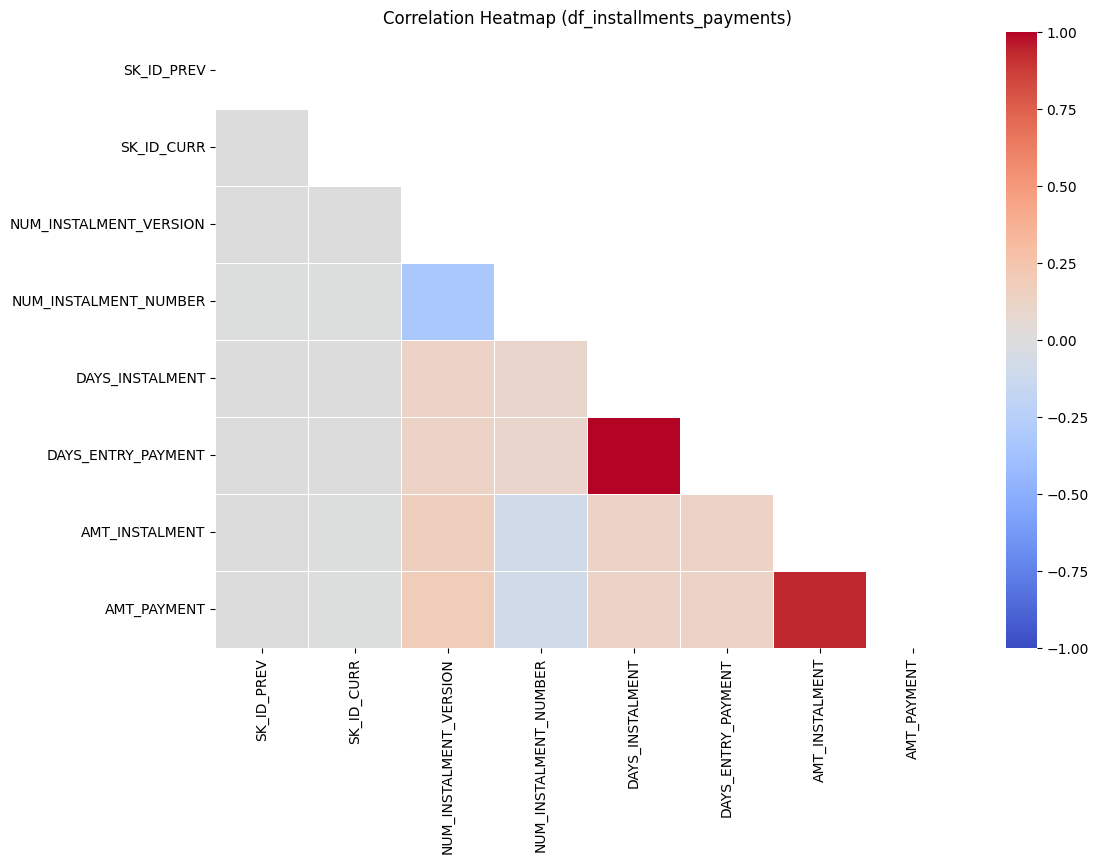

In [30]:
# Visualize the correlation matrix using a heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 

# Set figure size
plt.figure(figsize=(12, 8))

# Create heatmap
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=False, 
    cmap="coolwarm", 
    linewidths=0.5, 
    vmin=-1, vmax=1
)

# Title
plt.title("Correlation Heatmap (df_installments_payments)")
plt.show()

### Key Takeaways:
- **Strong positive correlations (~1.0)** exist between `DAYS_INSTALLMENT` and `DAYS_ENTRY_PAYMENT`, as well as `AMT_INSTALMENT` and `AMT_PAYMENT`, indicating that these features capture similar information.
- **Moderate correlations** between `NUM_INSTALLMENT_VERSION` and `NUM_INSTALLMENT_NUMBER` suggest some level of relationship, but they are not fully redundant.
- **Potential feature reduction**: To avoid multicollinearity, `DAYS_ENTRY_PAYMENT` or `DAYS_INSTALLMENT` could be dropped or combined, and similarly, `AMT_PAYMENT` or `AMT_INSTALMENT` might be simplified if needed.

### 4.4 Visualizing Outliers  

We plot boxplots of key numerical features to detect **potential extreme values**.  
Since LightGBM handles outliers efficiently, **no transformations** are applied.  

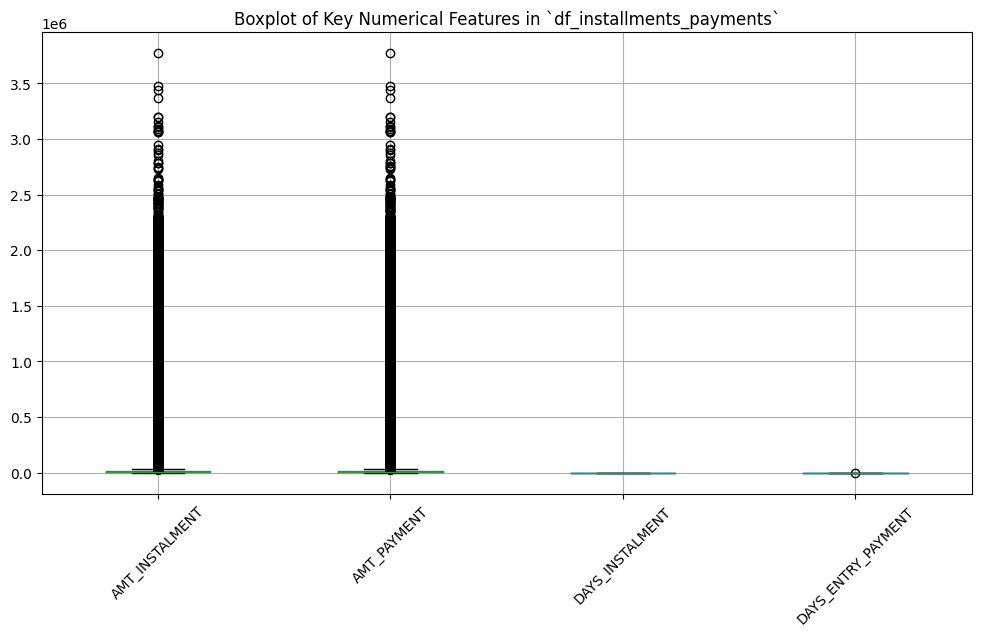

In [31]:
# Selected key numeric features for outlier detection
outlier_columns = [
    "AMT_INSTALMENT", "AMT_PAYMENT", "DAYS_INSTALMENT", "DAYS_ENTRY_PAYMENT"
]

# Create boxplot
plt.figure(figsize=(12, 6))
df_installments_payments[outlier_columns].boxplot()

# Title
plt.title("Boxplot of Key Numerical Features in `df_installments_payments`")
plt.xticks(rotation=45)  
plt.show()

### Key Takeaways:
- **Extreme values are present** in `AMT_INSTALMENT` and `AMT_PAYMENT`, with a significant number of high-value outliers.
- **DAYS_INSTALLMENT and DAYS_ENTRY_PAYMENT** exhibit a more stable distribution, with fewer extreme values.
- **Handling strategy:** While LightGBM can handle outliers effectively, potential extreme values in `AMT_INSTALMENT` and `AMT_PAYMENT` should be monitored to avoid skewed model learning.

### 4.5 Pair Plot Analysis (`installments_payments.csv`)
Pair plots are not included for this dataset as they are better suited for static features rather than time-series-like transaction data. Instead, we focus on histograms and scatter plots for clearer insights into repayment patterns.

### 4.6 Group-wise Analysis (`installments_payments.csv`)
This dataset does not contain categorical features, so boxplots grouped by categorical variables are not applicable. Instead, we focus on numerical distributions and repayment patterns.

### 4.7 Time-wise Analysis
We analyze how key features evolve over time to detect **trends, seasonality, or anomalies**.  
This helps in identifying patterns that might improve feature engineering. 

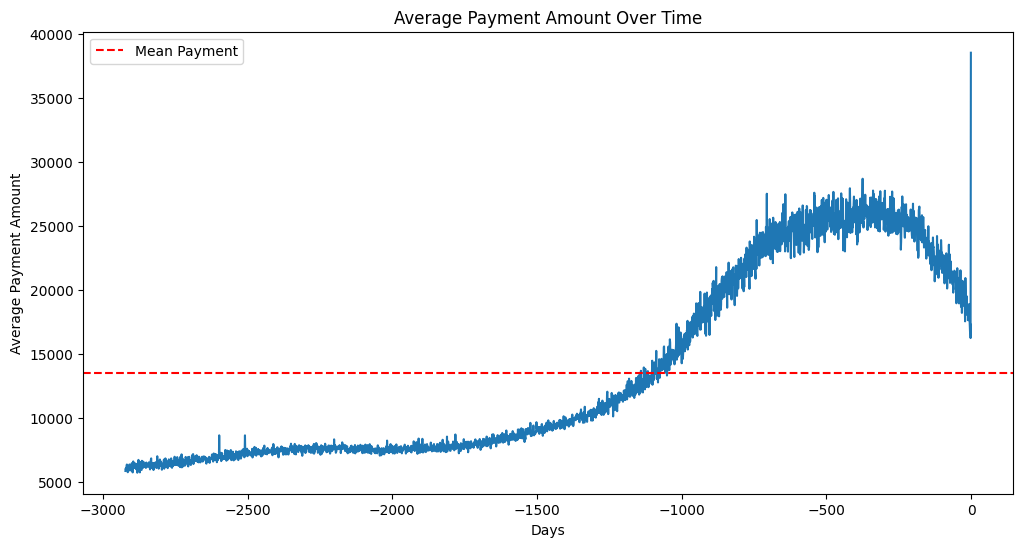

In [32]:
# Average payment amount over time
df_time = df_installments_payments.groupby("DAYS_INSTALMENT")["AMT_PAYMENT"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="DAYS_INSTALMENT", y="AMT_PAYMENT", data=df_time)
plt.axhline(df_time["AMT_PAYMENT"].mean(), linestyle="--", color="red", label="Mean Payment")
plt.title("Average Payment Amount Over Time")
plt.xlabel("Days")
plt.ylabel("Average Payment Amount")
plt.legend()
plt.show()

### Key Takeaways:
- **Upward trend observed:** The **average payment amount** has increased over time, especially in the last 1000 days.
- **Recent decline detected:** A drop in the average payment amount is visible closer to the present, suggesting potential shifts in repayment behavior.
- **Potential insights for modeling:** The payment trend could indicate **changes in loan policies, economic factors, or borrower behavior**, making **time-based features valuable for prediction**.

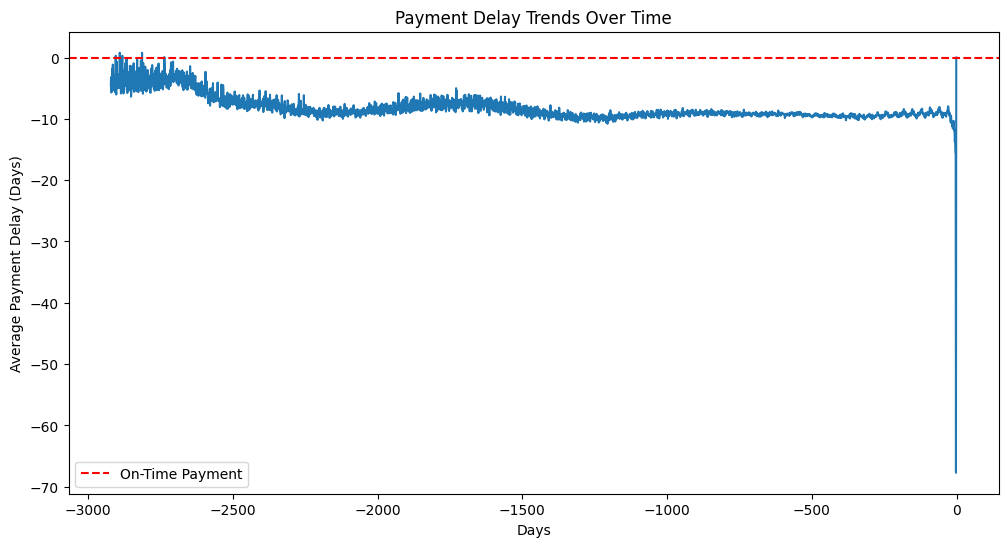

In [33]:
# Payment delays over time
df_time_delay = df_installments_payments.groupby("DAYS_INSTALMENT")["DAYS_ENTRY_PAYMENT"].mean().reset_index()
df_time_delay["PAYMENT_DELAY"] = df_time_delay["DAYS_ENTRY_PAYMENT"] - df_time_delay["DAYS_INSTALMENT"]

plt.figure(figsize=(12, 6))
sns.lineplot(x="DAYS_INSTALMENT", y="PAYMENT_DELAY", data=df_time_delay)
plt.axhline(0, linestyle="--", color="red", label="On-Time Payment")
plt.title("Payment Delay Trends Over Time")
plt.xlabel("Days")
plt.ylabel("Average Payment Delay (Days)")
plt.legend()
plt.show()

### Key Takeaways:
- **Consistently negative delays:** Most payments are made **before the due date**, with the average delay stabilizing around **10-15 days early**.
- **Gradual decline in delay time:** Borrowers have been making payments **increasingly earlier over time**, suggesting **improved repayment behavior or stricter loan policies**.
- **Recent anomaly near present time:** A sharp drop at the end indicates **a potential data issue or a sudden shift in repayment patterns**, which may require further investigation.

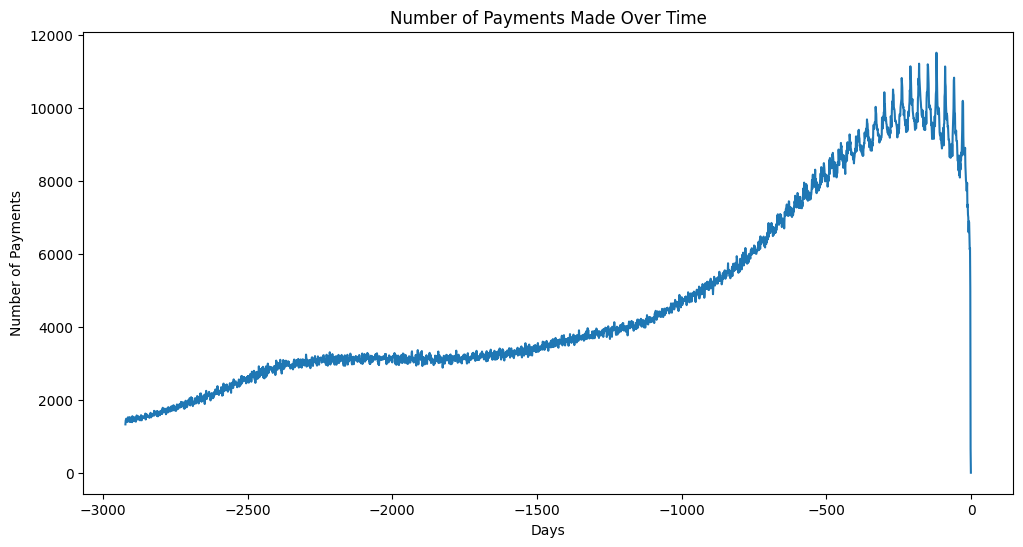

In [34]:
# Total payments made per time period
df_count = df_installments_payments.groupby("DAYS_INSTALMENT")["SK_ID_PREV"].count().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="DAYS_INSTALMENT", y="SK_ID_PREV", data=df_count)
plt.title("Number of Payments Made Over Time")
plt.xlabel("Days")
plt.ylabel("Number of Payments")
plt.show()

### Key Takeaways:
- **Steady increase in payments:** The number of payments gradually increased over time, reflecting a growing volume of loan transactions.
- **Seasonal fluctuations appear in later periods:** Noticeable cyclical patterns emerge closer to the present, indicating **possible periodic repayment behaviors** (e.g., monthly or quarterly cycles).
- **Sharp drop near present time:** The recent decline suggests **either a data cutoff issue or a significant drop in loan payments**, which may warrant further investigation.

### 4.8 Joint Plot Analysis
We use scatter plots with histograms to visualize relationships between numerical features.  
This helps identify patterns, correlations, and potential outliers.

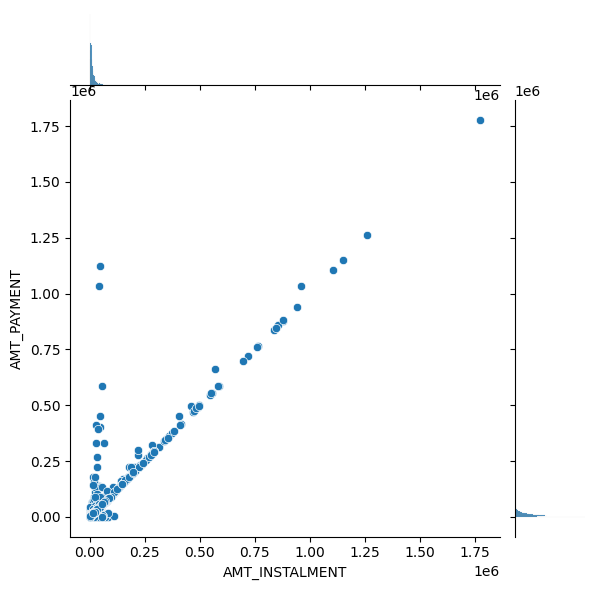

In [35]:
# Sample 10,000 rows for performance
df_sample_scatter = df_installments_payments.sample(n=10000, random_state=42)

# Scatter plot of Expected Installment vs. Actual Payment
sns.jointplot(x="AMT_INSTALMENT", y="AMT_PAYMENT", data=df_sample_scatter, kind="scatter")

plt.title("Scatter Plot: AMT_INSTALMENT vs. AMT_PAYMENT")
plt.show()

### Key Takeaways:
- **Strong linear relationship:** Most points align closely with the diagonal, suggesting that in many cases, the **actual payment (`AMT_PAYMENT`) closely matches the expected installment (`AMT_INSTALMENT`)**.
- **Instances of overpayment and underpayment:** Some points **above the diagonal** indicate **overpayment**, while those **below it** indicate **underpayment**.
- **Clusters near zero:** There is a dense cluster near `(0,0)`, potentially representing **small installment amounts or missing data**.
- **Outliers with high amounts:** A few extreme values suggest possible **unusual transactions**, which could be further investigated.

### 4.9 Additional EDA Visualisations

We plot histograms to visualize the distribution of key numerical features.  
This helps detect skewness, outliers, and possible data transformations.

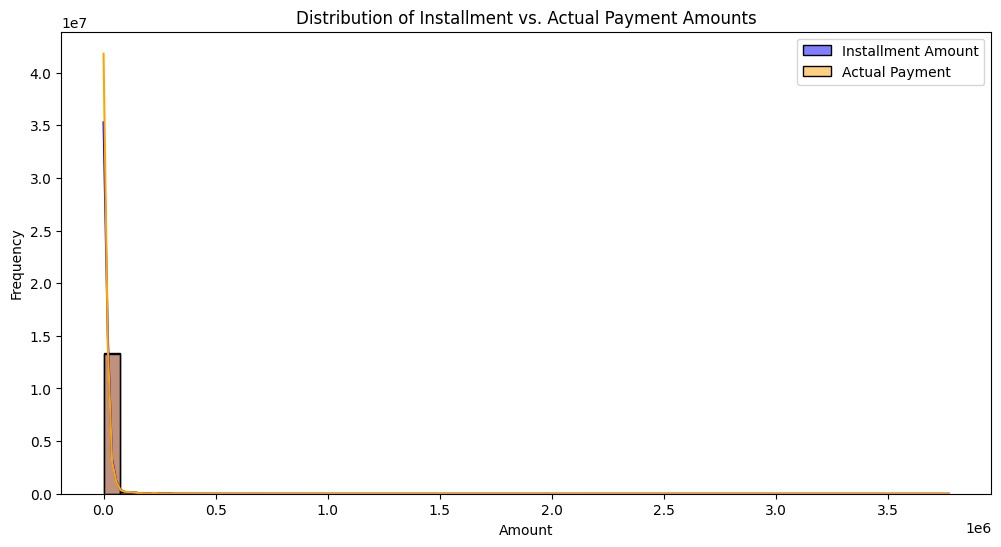

In [36]:
# Payment amount distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_installments_payments["AMT_INSTALMENT"], bins=50, kde=True, color="blue", label="Installment Amount")
sns.histplot(df_installments_payments["AMT_PAYMENT"], bins=50, kde=True, color="orange", label="Actual Payment")
plt.title("Distribution of Installment vs. Actual Payment Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Key Takeaways:
- **Highly skewed distribution:** Both `AMT_INSTALMENT` (expected payment) and `AMT_PAYMENT` (actual payment) are **heavily right-skewed**, meaning most payments are **small amounts**, with a few **very large values**.
- **Close overlap of distributions:** The two curves align closely, indicating that **actual payments generally match expected installments**.
- **Minor variations in density:** While the alignment suggests good repayment adherence, small differences could signal cases of **overpayment or underpayment**.
- **Extreme values (outliers):** There are a few **high-value transactions** that might represent **large loans or anomalies**, which could require further investigation.

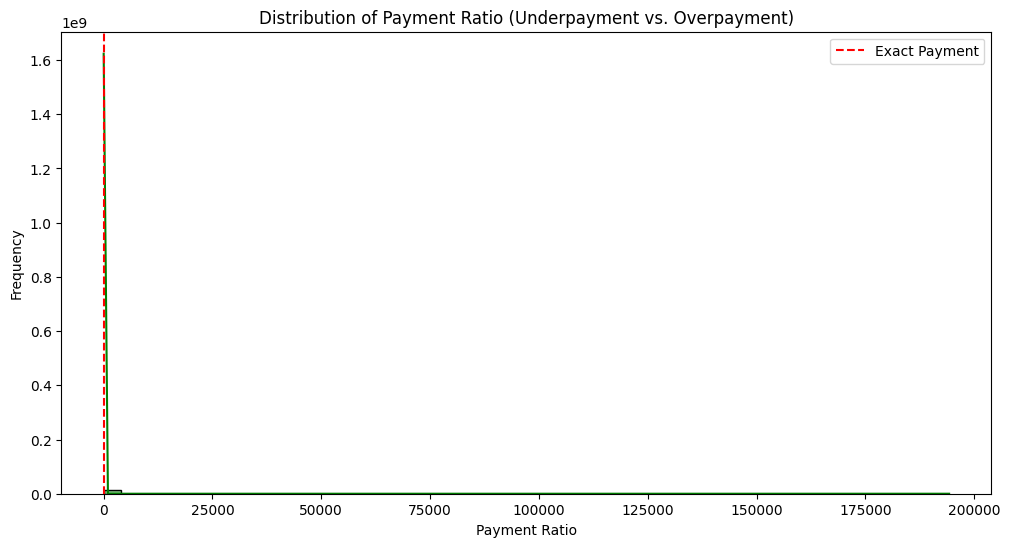

In [37]:
# Payment ratio (underpayment vs. overpayment)
# Safely compute Payment Ratio to prevent division by zero
df_installments_payments["PAYMENT_RATIO"] = df_installments_payments["AMT_PAYMENT"] / df_installments_payments["AMT_INSTALMENT"].replace(0, np.nan)

plt.figure(figsize=(12, 6))
sns.histplot(df_installments_payments["PAYMENT_RATIO"], bins=50, kde=True, color="green")
plt.axvline(1, color="red", linestyle="--", label="Exact Payment")
plt.title("Distribution of Payment Ratio (Underpayment vs. Overpayment)")
plt.xlabel("Payment Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Key Takeaways  
- The distribution of the payment ratio is **highly skewed**, with extreme outliers causing most data to be compressed along the y-axis.
- The majority of payments are **near 1.0**, meaning most payments match the expected installment amount.
- Some cases show **significant underpayment (ratio < 1.0) and extreme overpayment (ratio >> 1.0)**.
- While attempts were made to **zoom in** or use a **logarithmic scale**, the extreme values distort visibility.
- Keeping the full distribution ensures transparency, but a truncated version (e.g., focusing on `0-5` range) might help for exploratory analysis.

We analyze the distribution of key categorical features using bar plots.  
This helps identify class imbalances, dominant categories, and rare values.

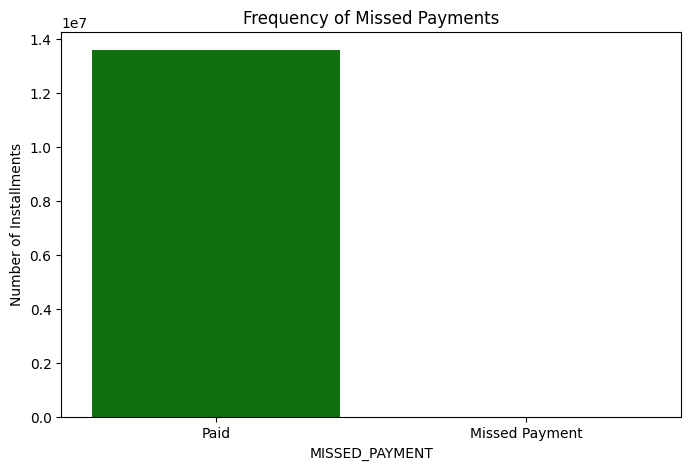

In [38]:
# Missed payments frequency
df_installments_payments["MISSED_PAYMENT"] = (df_installments_payments["AMT_PAYMENT"] == 0).astype(int)

plt.figure(figsize=(8, 5))
sns.barplot(x=df_installments_payments["MISSED_PAYMENT"].value_counts().index, 
            y=df_installments_payments["MISSED_PAYMENT"].value_counts().values, palette=["green", "red"])
plt.xticks([0, 1], ["Paid", "Missed Payment"])
plt.title("Frequency of Missed Payments")
plt.ylabel("Number of Installments")
plt.show()

### Key Takeaways  
- The vast majority of installments were **paid on time** (green bar).
- **Missed payments (red bar) are rare**, but their impact could be significant in predicting credit risk.
- The stark imbalance suggests that **missed payments are an important but minority class**.
- Further analysis could explore how missed payments correlate with loan defaults or other financial behaviors.

## 5. Feature Engineering (`installments_payments.csv`)
We create new features to enhance predictive power by summarizing key attributes of the dataset.  
Feature engineering helps capture meaningful patterns that might improve model performance.

### 5.1 Credit Activity Features  
Summarize the number of payments made per client, including the total number of missed payments and the ratio of missed payments to total payments.

In [39]:
# Group by SK_ID_CURR and calculate credit activity features
installments_credit_activity = df_installments_payments.groupby("SK_ID_CURR").agg(
    installments_NUM_PAYMENTS=("SK_ID_PREV", "count"),  # Total number of payments made
    installments_NUM_MISSED_PAYMENTS=("MISSED_PAYMENT", "sum"),  # Total number of missed payments
    installments_MISSED_PAYMENT_RATIO=("MISSED_PAYMENT", lambda x: x.mean())  # Ratio of missed payments
).reset_index()

# Preview the new features before merging
display(installments_credit_activity.head())

,SK_ID_CURR,installments_NUM_PAYMENTS,installments_NUM_MISSED_PAYMENTS,installments_MISSED_PAYMENT_RATIO
0,100001,7,0,0.0
1,100002,19,0,0.0
2,100003,25,0,0.0
3,100004,3,0,0.0
4,100005,9,0,0.0


### 5.2 Loan Amount Features  
Summarize the expected and actual payment amounts per client, including averages and totals, to capture loan repayment behavior.

In [40]:
# Group by SK_ID_CURR and calculate loan amount features
installments_loan_amount = df_installments_payments.groupby("SK_ID_CURR").agg(
    installments_MEAN_INSTALMENT_AMOUNT=("AMT_INSTALMENT", "mean"),  # Avg expected installment amount
    installments_MEAN_ACTUAL_PAYMENT=("AMT_PAYMENT", "mean"),  # Avg actual payment made
    installments_SUM_INSTALMENT_AMOUNT=("AMT_INSTALMENT", "sum"),  # Total expected installment amount
    installments_SUM_ACTUAL_PAYMENT=("AMT_PAYMENT", "sum"),  # Total actual paid amount
).reset_index()

# Compute Payment Compliance Ratio (Avoid division by zero)
installments_loan_amount["installments_PAYMENT_COMPLIANCE_RATIO"] = (
    installments_loan_amount["installments_SUM_ACTUAL_PAYMENT"] / installments_loan_amount["installments_SUM_INSTALMENT_AMOUNT"]
)
installments_loan_amount["installments_PAYMENT_COMPLIANCE_RATIO"] = installments_loan_amount["installments_PAYMENT_COMPLIANCE_RATIO"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Preview the new features before merging
display(installments_loan_amount.head())

,SK_ID_CURR,installments_MEAN_INSTALMENT_AMOUNT,installments_MEAN_ACTUAL_PAYMENT,installments_SUM_INSTALMENT_AMOUNT,installments_SUM_ACTUAL_PAYMENT,installments_PAYMENT_COMPLIANCE_RATIO
0,100001,5885.132143,5885.132143,41195.925,41195.925,1.0
1,100002,11559.247105,11559.247105,219625.695,219625.695,1.0
2,100003,64754.586000,64754.586000,1618864.650,1618864.650,1.0
3,100004,7096.155000,7096.155000,21288.465,21288.465,1.0
4,100005,6240.205000,6240.205000,56161.845,56161.845,1.0


### 5.3 Time-Based Features  
Summarize key temporal patterns in payment history, including average, earliest, and most recent payment dates.

In [41]:
# Group by SK_ID_CURR and calculate time-based features
installments_time_based = df_installments_payments.groupby("SK_ID_CURR").agg(
    installments_MEAN_DAYS_ENTRY_PAYMENT=("DAYS_ENTRY_PAYMENT", "mean"),  # Avg days when payment was made
    installments_STD_DAYS_ENTRY_PAYMENT=("DAYS_ENTRY_PAYMENT", "std"),  # Std deviation (payment consistency)
    installments_MIN_DAYS_ENTRY_PAYMENT=("DAYS_ENTRY_PAYMENT", "min"),  # Earliest payment recorded
    installments_MAX_DAYS_ENTRY_PAYMENT=("DAYS_ENTRY_PAYMENT", "max"),  # Most recent payment recorded
    installments_MEAN_DAYS_INSTALMENT=("DAYS_INSTALMENT", "mean"),  # Avg expected due date of installment
    installments_MIN_DAYS_INSTALMENT=("DAYS_INSTALMENT", "min"),  # Earliest expected due date
    installments_MAX_DAYS_INSTALMENT=("DAYS_INSTALMENT", "max"),  # Most recent due date
).reset_index()

# Compute Additional Temporal Features
installments_time_based["installments_TIME_SINCE_LAST_PAYMENT"] = abs(installments_time_based["installments_MAX_DAYS_ENTRY_PAYMENT"])
installments_time_based["installments_MEAN_PAYMENT_DELAY"] = abs(installments_time_based["installments_MEAN_DAYS_ENTRY_PAYMENT"] - installments_time_based["installments_MEAN_DAYS_INSTALMENT"])

# Preview the new features before merging
display(installments_time_based.head())

,SK_ID_CURR,installments_MEAN_DAYS_ENTRY_PAYMENT,installments_STD_DAYS_ENTRY_PAYMENT,installments_MIN_DAYS_ENTRY_PAYMENT,installments_MAX_DAYS_ENTRY_PAYMENT,installments_MEAN_DAYS_INSTALMENT,installments_MIN_DAYS_INSTALMENT,installments_MAX_DAYS_INSTALMENT,installments_TIME_SINCE_LAST_PAYMENT,installments_MEAN_PAYMENT_DELAY
0,100001,-2195.0,643.904237,-2916,-1628,-2187.714286,-2916,-1619,1628,7.285714
1,100002,-315.421053,172.058877,-587,-49,-295.0,-565,-25,49,20.421053
2,100003,-1385.32,757.325432,-2324,-544,-1378.16,-2310,-536,544,7.16
3,100004,-761.666667,34.019602,-795,-727,-754.0,-784,-724,727,7.666667
4,100005,-609.555556,90.554005,-736,-470,-586.0,-706,-466,470,23.555556


### 5.4 Credit Overdue Features  
Capture late payment statistics, including average delay, standard deviation, and proportion of late payments.

In [42]:
# Precompute late payment flag (avoids repeated computation)
df_installments_payments["LATE_PAYMENT"] = (df_installments_payments["DAYS_ENTRY_PAYMENT"] > df_installments_payments["DAYS_INSTALMENT"]).astype(int)

# Compute payment delay before aggregation to speed up processing
df_installments_payments["PAYMENT_DELAY"] = df_installments_payments["DAYS_ENTRY_PAYMENT"] - df_installments_payments["DAYS_INSTALMENT"]

# 🔹 Group by SK_ID_CURR and calculate overdue-related statistics efficiently
installments_overdue = df_installments_payments.groupby("SK_ID_CURR").agg(
    installments_MEAN_PAYMENT_DELAY=("PAYMENT_DELAY", "mean"),  # Avg delay in payment
    installments_STD_PAYMENT_DELAY=("PAYMENT_DELAY", "std"),  # Std deviation of delays
    installments_NUM_LATE_PAYMENTS=("LATE_PAYMENT", "sum"),  # Count of late payments
    installments_LATE_PAYMENT_RATIO=("LATE_PAYMENT", "mean")  # Proportion of late payments
).reset_index()

# ✅ Preview the new features before merging
display(installments_overdue.head())

,SK_ID_CURR,installments_MEAN_PAYMENT_DELAY,installments_STD_PAYMENT_DELAY,installments_NUM_LATE_PAYMENTS,installments_LATE_PAYMENT_RATIO
0,100001,-7.285714,14.625483,1,0.142857
1,100002,-20.421053,4.925171,0,0.000000
2,100003,-7.16,3.726929,0,0.000000
3,100004,-7.666667,4.163332,0,0.000000
4,100005,-23.555556,13.510284,1,0.111111


### 5.5 Categorical Features Aggregation (`installments_payments.csv`)

This dataset does not contain categorical features, so this section is skipped to maintain consistency across notebooks.  

## 6. Aggregation (`installments_payments.csv`)
We aggregate numerical and categorical features at the client level to summarize loan-related patterns. This reduces dataset size while retaining essential information.

### 6.1 Aggregate All Numeric and Categorical Columns
- Numerical features are aggregated using mean, sum, max, and min to capture overall trends.
- Categorical features are aggregated using the most frequent category per client.

This step ensures that client-level insights are preserved for modeling while reducing redundancy.

In [43]:
# Aggregate df_installments_payments before merging
print("\nAggregating df_installments_payments by SK_ID_CURR...")

# Exclude SK_ID_PREV (installment-level unique identifier)
agg_numeric_columns = df_installments_payments.select_dtypes(include=['number']).drop(columns=['SK_ID_PREV'], errors='ignore')

# Aggregate numerical features (without std for cleaner results)
agg_funcs = ['mean', 'sum', 'max', 'min']
agg_numeric = agg_numeric_columns.groupby('SK_ID_CURR').agg(agg_funcs)

# Rename columns to avoid multi-index issue
agg_numeric.columns = ['installments_agg_' + '_'.join(col) for col in agg_numeric.columns]
agg_numeric.reset_index(inplace=True)

# No categorical columns in this dataset, so skip categorical aggregation
df_installments_payments_aggregated = agg_numeric

# Check new shape
print(f"✅ Aggregation complete. New df_installments_payments_aggregated shape: {df_installments_payments_aggregated.shape}")

# Preview the aggregated dataframe
display(df_installments_payments_aggregated.head())


Aggregating df_installments_payments by SK_ID_CURR...
✅ Aggregation complete. New df_installments_payments_aggregated shape: (339587, 41)


,SK_ID_CURR,installments_agg_NUM_INSTALMENT_VERSION_mean,installments_agg_NUM_INSTALMENT_VERSION_sum,installments_agg_NUM_INSTALMENT_VERSION_max,installments_agg_NUM_INSTALMENT_VERSION_min,installments_agg_NUM_INSTALMENT_NUMBER_mean,installments_agg_NUM_INSTALMENT_NUMBER_sum,installments_agg_NUM_INSTALMENT_NUMBER_max,installments_agg_NUM_INSTALMENT_NUMBER_min,installments_agg_DAYS_INSTALMENT_mean,...,installments_agg_MISSED_PAYMENT_max,installments_agg_MISSED_PAYMENT_min,installments_agg_LATE_PAYMENT_mean,installments_agg_LATE_PAYMENT_sum,installments_agg_LATE_PAYMENT_max,installments_agg_LATE_PAYMENT_min,installments_agg_PAYMENT_DELAY_mean,installments_agg_PAYMENT_DELAY_sum,installments_agg_PAYMENT_DELAY_max,installments_agg_PAYMENT_DELAY_min
0,100001,1.142857,8,2,1,2.714286,19,4,1,-2187.714286,...,0,0,0.142857,1,1,0,-7.285714,-51,11,-36
1,100002,1.052632,20,2,1,10.000000,190,19,1,-295.0,...,0,0,0.000000,0,0,0,-20.421053,-388,-12,-31
2,100003,1.04,26,2,1,5.080000,127,12,1,-1378.16,...,0,0,0.000000,0,0,0,-7.16,-179,-1,-14
3,100004,1.333333,4,2,1,2.000000,6,3,1,-754.0,...,0,0,0.000000,0,0,0,-7.666667,-23,-3,-11
4,100005,1.111111,10,2,1,5.000000,45,9,1,-586.0,...,0,0,0.111111,1,1,0,-23.555556,-212,1,-37


## 7. Merging (`installments_payments.csv`)
We merge all newly created feature tables into a single dataset using a **left join on SK_ID_CURR**.  
This ensures that no client records are lost while incorporating the engineered features.

In [44]:
# Function to safely merge dataframes and print debugging info
def safe_merge(df_main, df_new, merge_on="SK_ID_CURR", name=""):
    """ Merges two dataframes and prints sanity checks """
    prev_shape = df_main.shape
    df_main = df_main.merge(df_new, on=merge_on, how="left")

    print(f"✅ Merged {name}: {prev_shape} -> {df_main.shape}")
    missing_values = df_main.isnull().sum()[df_main.isnull().sum() > 0]
    
    if not missing_values.empty:
        print(f"⚠️ Missing Values in {name} After Merge:\n{missing_values}")
    
    print("-" * 50)
    return df_main

# Apply Safe Merges for Installments Payments Features
df_installments_payments_aggregated = safe_merge(df_installments_payments_aggregated, installments_credit_activity, name="installments_credit_activity")
df_installments_payments_aggregated = safe_merge(df_installments_payments_aggregated, installments_loan_amount, name="installments_loan_amount")
df_installments_payments_aggregated = safe_merge(df_installments_payments_aggregated, installments_time_based, name="installments_time_based")
df_installments_payments_aggregated = safe_merge(df_installments_payments_aggregated, installments_overdue, name="installments_overdue")

print("✅ All installments payments feature tables merged successfully!")

✅ Merged installments_credit_activity: (339587, 41) -> (339587, 44)
⚠️ Missing Values in installments_credit_activity After Merge:
installments_agg_PAYMENT_RATIO_mean    3
installments_agg_PAYMENT_RATIO_max     3
installments_agg_PAYMENT_RATIO_min     3
dtype: int64
--------------------------------------------------
✅ Merged installments_loan_amount: (339587, 44) -> (339587, 49)
⚠️ Missing Values in installments_loan_amount After Merge:
installments_agg_PAYMENT_RATIO_mean    3
installments_agg_PAYMENT_RATIO_max     3
installments_agg_PAYMENT_RATIO_min     3
dtype: int64
--------------------------------------------------
✅ Merged installments_time_based: (339587, 49) -> (339587, 58)
⚠️ Missing Values in installments_time_based After Merge:
installments_agg_PAYMENT_RATIO_mean      3
installments_agg_PAYMENT_RATIO_max       3
installments_agg_PAYMENT_RATIO_min       3
installments_STD_DAYS_ENTRY_PAYMENT    972
dtype: int64
--------------------------------------------------
✅ Merged instal

In [45]:
# Handle NaNs in standard deviation columns by filling with 0
df_installments_payments_aggregated["installments_STD_DAYS_ENTRY_PAYMENT"] = df_installments_payments_aggregated["installments_STD_DAYS_ENTRY_PAYMENT"].fillna(0)
df_installments_payments_aggregated["installments_STD_PAYMENT_DELAY"] = df_installments_payments_aggregated["installments_STD_PAYMENT_DELAY"].fillna(0)

# Handle NaNs in Payment Ratio Aggregates
# Since missing values in PAYMENT_RATIO occur when AMT_INSTALMENT == 0, we assume full payment was made
df_installments_payments_aggregated["installments_agg_PAYMENT_RATIO_mean"] = df_installments_payments_aggregated["installments_agg_PAYMENT_RATIO_mean"].fillna(1)
df_installments_payments_aggregated["installments_agg_PAYMENT_RATIO_max"] = df_installments_payments_aggregated["installments_agg_PAYMENT_RATIO_max"].fillna(1)
df_installments_payments_aggregated["installments_agg_PAYMENT_RATIO_min"] = df_installments_payments_aggregated["installments_agg_PAYMENT_RATIO_min"].fillna(1)

### 7.1 Feature Validation
Before saving, we validate the dataset by checking for:  
- **Missing values** (standard NaNs and hidden NaNs stored as text)  
- **Infinite values** (Inf or -Inf, which can cause issues in modeling)  

Once verified, the aggregated dataset is saved.

In [46]:
# Step 1: Check for standard NaN values
missing_values_installments_aggregated = df_installments_payments_aggregated.isna().sum()
missing_values_installments_aggregated = missing_values_installments_aggregated[missing_values_installments_aggregated > 0]

print("\nStandard Missing Values in Aggregated Installments Payments Features After Merging:")
print(missing_values_installments_aggregated if not missing_values_installments_aggregated.empty else "✅ No standard NaN values detected.")

# Step 2: Check for hidden NaNs (empty strings or "nan" stored as a string)
hidden_nans_installments_aggregated = (df_installments_payments_aggregated == "").sum() + (df_installments_payments_aggregated == "nan").sum()
hidden_nans_installments_aggregated = hidden_nans_installments_aggregated[hidden_nans_installments_aggregated > 0]

print("\nHidden NaNs (Empty Strings or 'nan' as Text) in Aggregated Installments Payments Features After Merging:")
print(hidden_nans_installments_aggregated if not hidden_nans_installments_aggregated.empty else "✅ No hidden NaNs detected.")


Standard Missing Values in Aggregated Installments Payments Features After Merging:
✅ No standard NaN values detected.

Hidden NaNs (Empty Strings or 'nan' as Text) in Aggregated Installments Payments Features After Merging:
✅ No hidden NaNs detected.


In [47]:
# Step 3: Check for Inf values
inf_values_installments_aggregated = df_installments_payments_aggregated.replace([np.inf, -np.inf], np.nan).isna().sum()
inf_values_installments_aggregated = inf_values_installments_aggregated[inf_values_installments_aggregated > 0]

print("\nInfinite Values in Aggregated Installments Payments Features After Merging:")
if inf_values_installments_aggregated.empty:
    print("✅ No Inf values detected.")
else:
    print(inf_values_installments_aggregated)


Infinite Values in Aggregated Installments Payments Features After Merging:
✅ No Inf values detected.


In [48]:
# Save aggregated installments payments dataset
df_installments_payments_aggregated.to_csv("installments_payments_aggregated.csv", index=False)
df_installments_payments_aggregated.to_pickle("installments_payments_aggregated.pkl")

print("✅ Installments Payments aggregated dataset saved successfully!")

✅ Installments Payments aggregated dataset saved successfully!
